<a href="https://colab.research.google.com/github/carolineChenCoder/Bert-Chinese-Text-Classification-Pytorch/blob/master/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a notebook that shows how to produce Grad-CAM visualizations for ALBEF

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
# %reload_ext autoreload
# %autoreload 0

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/attack/ALBEF')
!pip install cog
!pip install datasets

## 0. Do attack

### Image and Text Retrivel

#### Load Refcoco data

In [9]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import analyze as anl
import predict_cc as pc
from predict_cc import Predictor
from PIL import Image

# predictor = Predictor()
# predictor.setup()

# refcoco = load_dataset('lmms-lab/RefCOCO')
refcoco = load_dataset('lmms-lab/RefCOCO', cache_dir='/content/drive/MyDrive/attack/ALBEF/data_download/')

val_dataset = refcoco["val"]  # 或 refcoco["test"]
dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

Generating val split:   0%|          | 0/8811 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating testA split:   0%|          | 0/1975 [00:00<?, ? examples/s]

Generating testB split:   0%|          | 0/1810 [00:00<?, ? examples/s]

#### Load ALBEF model

In [ ]:
from models.vit import VisionTransformer
from models.xbert import BertConfig, BertModel
from models.tokenization_bert import BertTokenizer
from functools import partial
import torch
from torch import nn
from torchvision import transforms

class VL_Transformer_ITM(nn.Module):
    def __init__(self,
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()

        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)

        self.itm_head = nn.Linear(768, 2)


    def forward(self, image, text):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids,
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,
                                return_dict = True,
                               )

        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)
        return vl_output,output,vl_embeddings

# grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
# cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

bert_config_path='/content/drive/MyDrive/attack/ALBEF/configs/config_bert.json'
model_path = '/content/drive/MyDrive/attack/ALBEF/models_checkpoints/ALBEF_4M.pth'
bert_config = BertConfig.from_json_file(bert_config_path)

model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)
# text_encoder = BertModel.from_pretrained(text_encoder='bert-base-uncased', config=bert_config, add_pooling_layer=False)

checkpoint = torch.load(model_path, map_location='cuda')
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()



#### Extract features

In [ ]:
image_0=dataloader.dataset['image'][i]
dataloader.dataset

Dataset({
    features: ['question_id', 'image', 'question', 'answer', 'segmentation', 'bbox', 'iscrowd', 'file_name'],
    num_rows: 8811
})

In [ ]:
from IPython.display import display

image_org=[]
text_org=[]
len_ =len(dataloader.dataset['question_id'])

def preprocess_image(image_path):
    # image = Image.open(image_path).convert("RGB")
    image = image_path.convert("RGB")
    image = predictor.transform(image).unsqueeze(0)
    return image

def preprocess_text(text):
    inputs = predictor.tokenizer(text, padding="max_length",truncation=True, return_tensors="pt").to('cuda')
    return inputs

image_list=[]
text_list = []
for i in range(1000):
  print(i)
  image = dataloader.dataset['image'][i]
  text = dataloader.dataset['answer'][i]
  image_list.append(preprocess_image(image))
  text_list.append(preprocess_text(text))
  image_org.append(image)
  text_org.append(text)


#### CLIP feature

In [16]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# # 加载模型（无需额外安装）
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 提取图像特征
image = image
inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)  # [1, 512]

# 提取文本特征
text = ["a photo of a cat", "a dog playing in the park"]
inputs = processor(text=text, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs)  # [2, 512]

# 计算相似度
similarity = (image_features @ text_features.T).softmax(dim=-1)
print(similarity)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tensor([[9.9903e-01, 9.6727e-04]], device='cuda:0')


#### TCL features

In [ ]:
from transformers import TCLProcessor, TCLModel
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and processor
model = TCLModel.from_pretrained("microsoft/tcl-base").to(device)
processor = TCLProcessor.from_pretrained("microsoft/tcl-base")

image = Image.open("your_image.jpg").convert("RGB")

# Preprocess and encode image
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_features = model.get_image_features(​**​inputs)  # Shape: [1, feature_dim]

print("Image features shape:", image_features.shape)  # e.g., [1, 768]

text = "a photo of a cat"

# Preprocess and encode text
inputs = processor(text=text, return_tensors="pt").to(device)
with torch.no_grad():
    text_features = model.get_text_features(​**​inputs)  # Shape: [1, feature_dim]

print("Text features shape:", text_features.shape)  # e.g., [1, 768]

similarity = torch.cosine_similarity(image_features, text_features, dim=1)
print("Image-Text Similarity:", similarity.item())  # Range: [-1, 1]

#### Extract feature from BLIP

In [ ]:
from transformers import BlipProcessor, BlipModel
import torch
from PIL import Image

# 加载 BLIP 模型和处理器
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipModel.from_pretrained("Salesforce/blip-itm-base-coco").to(device)
processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

#### ALBEF feature

In [ ]:
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)
def extract_features(model, images, texts):
    # 提取所有图像特征
    image_features = []
    for img in tqdm(images, desc="Extracting image features"):
        img = img.to(device)
        with torch.no_grad():
            features = model.visual_encoder(img)
        image_features.append(features.cpu().numpy())
    image_features = np.concatenate(image_features, axis=0)

    # 提取所有文本特征
    text_features = []
    for text in tqdm(texts, desc="Extracting text features"):
        with torch.no_grad():
            features = model.text_encoder(**text,mode="text")
        text_embeddings = features.last_hidden_state
        text_features.append(text_embeddings.cpu().numpy())
    text_features = np.concatenate(text_features, axis=0)

    return image_features, text_features

image_features, text_features = extract_features(model, image_list, text_list)

Extracting text features: 100%|██████████| 5/5 [00:00<00:00, 19.82it/s]


In [ ]:
text_data = [
    # 格式: (image_index, description)
    (0, 'bowl behind the others can only see part'),
    (0, 'Dish in top right corner'),
    (0, 'White dish in the top right corner.'),
    (0, 'white pot upper right corner'),
    (1, 'front bowl w/carrots in it'),
    (1, 'bowl of carrots'),
    (1, 'bowl of carrots'),
    (1, 'carrots'),
    (2, 'little girl'),
    (2, 'pink'),
    (2, "Your monitor's color's off, friend. ;p Pink shirt girl..."),
    (3, 'green woman'),
    (3, 'person holding umbrella'),
    (3, 'woman'),
    (4, 'mom'),
    (4, 'adult'),
    (4, 'lady sitting')
]

text_list = [desc for _, desc in text_data]  # 所有文本描述
image_indices = [img_idx for img_idx, _ in text_data]  # 对应的图像索引

def multimodal_retrieval(image_features, text_features, text_list, top_k=3):
    # 1. 提取图像全局特征
    query_features = image_features.mean(axis=1)  # (5,768)

    # 2. 提取文本全局特征
    text_embeddings = text_features[:, 0, :]  # (17,768)

    # 3. 归一化
    query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
    text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    # 4. 计算相似度
    similarity_matrix = np.dot(query_features, text_embeddings.T)  # (5,17)

    # 5. 对每个查询图像获取Top-K结果
    all_results = []
    for query_idx in range(len(query_features)):
        # 获取当前图像的相似度向量 (17,)
        sim_scores = similarity_matrix[query_idx]

        # 排序并保留索引
        ranked_indices = np.argsort(sim_scores)[::-1][:top_k]

        # 收集结果
        results = []
        for idx in ranked_indices:
            results.append({
                'query_image_idx': query_idx,
                'matched_text': text_list[idx],
                'matched_image_idx': image_indices[idx],  # 文本原始所属图像
                'similarity': sim_scores[idx]
            })
        all_results.append(results)

    return all_results
retrieval_results = multimodal_retrieval(image_features, text_features, text_list, top_k=1)

### VL_ITM

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch

refcoco = load_dataset('lmms-lab/RefCOCO')
val_dataset = refcoco["val"]  # 或 refcoco["test"]
dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:

from torchvision import transforms
import torch

# 图像预处理管道
preprocess = transforms.Compose([
    transforms.Resize((384, 384)),  # ALBEF标准输入尺寸
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    """处理RefCOCO数据集的批处理函数"""
    # 图像处理
    images = [preprocess(item["image"]) for item in batch]

    # 文本处理（取第一个answer作为文本描述）
    texts = [item["answer"][0] for item in batch]  # 使用answer字段而非sentences
    text_inputs = predictor.tokenizer(
        texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=30
    )
    bboxes = [torch.tensor(item["bbox"]) for item in batch] if "bbox" in batch[0] else []

    return {
        "images": torch.stack(images),  # [B, C, H, W]
        "texts": text_inputs,                # List[str]
        # "bboxes": torch.stack(bboxes) if bboxes else None  # [B, 4] or None
    }


dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(original, adversarial):
    """计算 PSNR (输入需为同形状的 Tensor)"""
    print(type(original),type(adversarial))
    mse = torch.mean((original - adversarial)**2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))  # 假设像素值范围为 [0,1]
    return psnr.item()

# # 调用示例
# psnr = calculate_psnr(image_tensor, adv_image)  # 确保两者已经是 Tensor

def calculate_ssim(original, adversarial):
    """计算 SSIM (结构相似性)"""
    original_np = original.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    adv_np = adversarial.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    return ssim(original_np, adv_np, multichannel=True, data_range=1.0)

In [ ]:
from collections import defaultdict
category_stats = defaultdict(int)

In [ ]:
import pandas as pd
import seaborn as sns

# # 生成统计图表
# results = pd.DataFrame(...)
# sns.barplot(x="category", y="success_rate", data=results)
# plt.title("Attack Success Rate by Object Category")

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    predictor = predictor# 实现你的模型加载函数

    # 运行评估
    success_rate = evaluate_attack_success_rate(
        predictor,
        dataloader,
        num_samples=1000  # 首次测试用较小样本量
    )

    # 保存结果
    with open("attack_results.txt", "w") as f:
        f.write(f"Final Success Rate: {success_rate:.2%}\n")

In [ ]:
def evaluate_attack_success_rate(predictor, dataloader, num_samples=1000):
    success_count = 0
    # total_psnr = 0
    image_pair=[]

    for idx, batch in enumerate(dataloader):
        if idx >= num_samples:
            break

        # image, text, bbox = batch["images"], batch["texts"], batch["bboxes"]
        image, text = batch["images"], batch["texts"]

        # text = predictor.tokenizer(text, return_tensors="pt").to('cuda')
        text = text.to(device)
        # image_tensor = preprocess(image).unsqueeze(0).to('cuda')
        image_tensor = image.to(device)

        # 原始预测
        # with torch.no_grad():
        original_output = predictor.model(image_tensor, text)
        original_pred = torch.argmax(original_output[0])

        # 生成对抗样本
        adv_image,noise_image, success = adaptive_epsilon_attack(
            predictor,
            image_tensor,
            text,
            max_iter=10,
            initial_epsilon=(0.1, 0.05, 0.05)
        )

        print(".....============result=======:",success)
        if success:
            success_count += 1
            # 计算视觉相似度
            image_pair.append([image_tensor, adv_image])
            # psnr = calculate_psnr(image_tensor, adv_image)
            # total_psnr += psnr

    success_rate = success_count / num_samples
    # avg_psnr = total_psnr / success_count if success_count > 0 else 0

    print(f"Attack Success Rate: {success_rate:.2%}")
    # print(f"Average PSNR (成功样本): {avg_psnr:.2f} dB")
    return success_rate

### Single attack succeed!

In [ ]:
# import torch
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# from torchvision import transforms
# import torch.nn.functional as F  # 新增导入
# import analyze as anl
# import predict_cc as pc
# from predict_cc import Predictor

# predictor = Predictor()
# predictor.setup()

image_path= "/content/drive/MyDrive/LLM/picture_examples/3white_dogs.jpg"
image_path = 'examples/image0.jpg'
image_pil = Image.open(image_path).convert('RGB')
image = predictor.transform(image_pil).unsqueeze(0).to('cuda')
image_tensor =image
# caption = 'Three white dogs stand together, their eyes fixed on some distant point.'
caption = 'the woman is working on her computer at the desk'
text = pc.pre_caption(caption)
text_input = predictor.tokenizer(text, return_tensors="pt").to('cuda')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

def adaptive_epsilon_attack(predictor, image, text_input, max_iter=20, initial_epsilon=(0.1, 0.05, 0.05)):
    device = image.device
    original_output = predictor.model(image, text_input)[0]
    original_pred = torch.argmax(original_output)

    # 初始化参数
    epsilon = torch.tensor(initial_epsilon, device=device,requires_grad=False).float()

    epsilon_decay = 0.9  # 每次衰减系数
    min_epsilon = 0.001  # 最小扰动阈值
    success = False

    # 准备对抗样本
    adv_image = image.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([adv_image], lr=0.01)

    for attempt in range(max_iter):
        print(f"Attempt {attempt+1}, epsilon: {epsilon.tolist()}")

        for i in range(2):  # 每个epsilon尝试2次优化
            optimizer.zero_grad()
            predictor.model.train()

            # 获取SVD分解结果
            svd_results, cross_attn = anl.analyze_cross_attention_svd(
                predictor.model, adv_image, text_input, num_layers=6, num_heads=12)

            layer = 6  # 攻击最后一层
            head = 0   # 第一个注意力头

            U = torch.from_numpy(svd_results[layer][head]['U']).float().to(device)
            S = torch.from_numpy(svd_results[layer][head]['singular_values']).float().to(device)
            Vh = torch.from_numpy(svd_results[layer][head]['Vh']).float().to(device)
            cross_attn_layer_head = torch.from_numpy(cross_attn[layer][head]).float().to(device)

            # 计算标准差
            std_S = torch.std(S)
            std_U = torch.std(U)
            std_Vh = torch.std(Vh)

            # 生成动态噪声
            delta_S = epsilon[0] * torch.randn_like(S) * std_S
            delta_U = epsilon[1] * 0.1 * torch.randn_like(U) * std_U
            delta_Vh = epsilon[2] * 0.1 * torch.randn_like(Vh) * std_Vh

            # 应用噪声
            S_perturbed = S + delta_S
            U_perturbed = U + delta_U
            Vh_perturbed = Vh + delta_Vh

            # print("...重建扰动后的注意力矩阵")
            attn_perturbed = U_perturbed @ torch.diag_embed(S_perturbed) @ Vh_perturbed

            # print("...计算损失")
            outputs = predictor.model(adv_image, text_input)
            logits = outputs[0]
            target = torch.zeros_like(logits)
            lambda_img = 0.5

            loss = (
                F.cross_entropy(logits, target)
                + 0.1 * F.mse_loss(attn_perturbed, cross_attn_layer_head)
                + lambda_img * F.mse_loss(adv_image, image_tensor)
            )
            # loss = F.cross_entropy(logits, target) + 0.1 * F.mse_loss(attn_perturbed, cross_attn_layer_head)

            # 反向传播
            loss.backward()
            optimizer.step()

            # 保持图像在合法范围内
            with torch.no_grad():
                  adv_image.data = torch.clamp(adv_image, image.min(), image.max())

        # print("...验证当前扰动是否成功")

        # with torch.no_grad():
        predictor.model.eval()
        current_output = predictor.model(adv_image, text_input)[0]
        current_pred = torch.argmax(current_output)
        # print('...result:',current_pred,original_pred)
        image_np = adv_image.detach().cpu().numpy()
        image_np = np.squeeze(image_np)
        image_np = np.transpose(image_np, (1, 2, 0))
        # print('...adv_image:',plt.imshow(image_np))
        if current_pred != original_pred:
            success = True
            print("Attack succeeded!")
            break
        else:
            # 如果没有成功，减小epsilon并继续尝试
            epsilon = torch.max(epsilon * epsilon_decay,
                              torch.tensor(min_epsilon, device=device))

    # 后处理
    adv_image_np = adv_image.squeeze().cpu().detach().numpy()
    adv_image_np = np.transpose(adv_image_np, (1, 2, 0))
    adv_image_np = (adv_image_np * 255).astype(np.uint8)
    adv_image_pil = Image.fromarray(adv_image_np)

    # 计算噪声
    original_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    noise = (adv_image_np - (original_np * 255).astype(np.uint8)).astype(np.float32)
    noise = (noise - noise.min()) / (noise.max() - noise.min()) * 255
    noise_pil = Image.fromarray(noise.astype(np.uint8))

    return adv_image_pil, noise_pil, success

Attempt 1, epsilon: [0.10000000149011612, 0.05000000074505806, 0.05000000074505806]
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
...验证当前扰动是否成功


...result: tensor(1, device='cuda:0') tensor(1, device='cuda:0')
...adv_image: AxesImage(shape=(384, 384, 3))
Attempt 2, epsilon: [0.08999999612569809, 0.044999998062849045, 0.044999998062849045]
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
...验证当前扰动是否成功


...result: tensor(1, device='cuda:0') tensor(1, device='cuda:0')
...adv_image: AxesImage(shape=(384, 384, 3))
Attempt 3, epsilon: [0.08099999278783798, 0.04049999639391899, 0.04049999639391899]
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
6
7
8
9
10
11
...重建扰动后的注意力矩阵
...计算损失
...验证当前扰动是否成功


...result: tensor(0, device='cuda:0') tensor(1, device='cuda:0')
...adv_image: AxesImage(shape=(384, 384, 3))
Attack succeeded!
成功生成对抗样本！


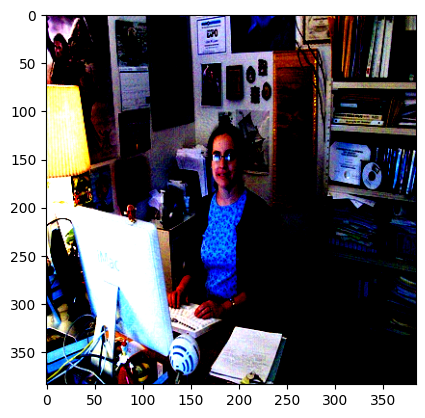

In [ ]:
# 假设已经初始化predictor, image_tensor, text_input
adv_image, noise, success = adaptive_epsilon_attack(
    predictor,
    image_tensor,
    text_input,
    max_iter=20,
    initial_epsilon=(0.1, 0.05, 0.05)
)

if success:
    print("成功生成对抗样本！")
    adv_image.show()
    noise.show()
else:
    print("未能找到足够小的有效扰动")

### Perturbation and extract singular

In [ ]:
def add_random_noise(embeddings, scale=0.1):
    noise = torch.randn_like(embeddings) * scale
    return noise

def add_targeted_perturbation(embeddings, token_indices, scale=0.1):
    perturbation = torch.zeros_like(embeddings)
    for idx in token_indices:
        perturbation[:, idx, :] = torch.randn(embeddings.size(2)) * scale
    return perturbation

In [ ]:
# Perform SVD and find the largest singular value
def get_largest_singular_value(cross_attention_matrix):
    # Flatten the matrix and perform SVD
    _, s, _ = torch.svd(cross_attention_matrix.view(-1, cross_attention_matrix.shape[-1]))
    largest_singular_value = s[0].item()
    return largest_singular_value

def perturb_image(model, inputs, original_image, num_iterations=100, lr=0.01):
    # Convert PIL image to tensor and make it require gradients
    image_tensor = transforms.ToTensor()(original_image).unsqueeze(0)#.to(model.device)  # Convert to tensor and add batch dimension
    image_tensor.requires_grad_(True)
    output, attention_output, vl_embeddings = model(image_tensor, text_input, perturb_image=perturb_image)#, perturb_text=perturb_text)

    optimizer = optim.Adam(image_tensor, lr=lr)

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Get attention matrix for the current image
        cross_attention_matrix = extract_attention(model, inputs)
        cross_attention_matrix = attention_output.attentions[0]

        # Calculate the largest singular value
        largest_singular_value = get_largest_singular_value(cross_attention_matrix)

        # Maximize the largest singular value by minimizing the negative value
        loss = -largest_singular_value
        loss.backward()

        optimizer.step()

        # Optionally clip the image to ensure it remains a valid image
        with torch.no_grad():
            image_tensor.data = torch.clamp(image_tensor.data, 0, 1)  # Ensure image is in valid range

    return image_tensor


transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])

# Apply perturbation and show the result
perturbed_image = perturb_image(model, text_input, image_pil)

# Convert the perturbed image back to a format suitable for display
perturbed_image_np = perturbed_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)

# Display the original and perturbed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(perturbed_image_np)
plt.title("Perturbed Image")

plt.show()

In [ ]:
# Get cross-attention weights from a specific layer
cross_attention_weights = attention_output.attentions[0]  # First cross-attention layer
# cross_attention_weights = attention_output.last_hidden_state[0]  # First cross-attention layer
avg_attention_weights = cross_attention_weights.mean(dim=1)  # Average over heads

# # Visualize the attention map for a specific text token
# text_token_idx = 5
# attention_to_image = avg_attention_weights[0, text_token_idx, :]
# attention_map = attention_to_image.detach().cpu().numpy().reshape(16, 16)  # Reshape to image patch grid

# import matplotlib.pyplot as plt
# plt.imshow(attention_map, cmap="viridis")
# plt.title(f"Attention Map for Text Token {text_token_idx}")
# plt.colorbar()
# plt.show()

In [ ]:
def modify_attention_hook(module, inputs, output):
    attention_weights = output[1]
    attention_weights[:, :, max_row_column[0],max_row_column[1]] = 0
    return output[0], attention_weights

hook = model.text_encoder.base_model.base_model.encoder.layer[6].crossattention.register_forward_hook(modify_attention_hook)


In [ ]:
captured_outputs = {}
def hook_function(module, input, output):
    captured_outputs['layer_6_crossatt_output'] = output
    captured_outputs['layer_6_crossatt_input'] = input

    print(f"Module: {module.__class__.__name__}")
    print(f"Input tensor shape: {input[0].shape}")

# Register this hook on the appropriate layer

# Assume `image` is your original image tensor
# Assume `text_input` is your input text tensor
# Gradient ascent to maximize the error
image.requires_grad = True
optimizer = torch.optim.Adam([image], lr=0.01)  # Small learning rate

for _ in range(2):
    optimizer.zero_grad()
    outputs = model(image,text_input)
    loss = criterion(outputs, 1)  # Define your criterion and target class appropriately
    (-loss).backward()  # Maximize loss
    optimizer.step()

# After the loop, `image` will be your adversarial example

model.eval()
with torch.no_grad():
    adversarial_output = model(text_input, image)
    print("Adversarial Output:", adversarial_output)


#### 2.1.1 Calculate the maxmium value in the causality graph

In [ ]:
import numpy as np
import torch
from torch.nn.functional import kl_div, softmax

def calculate_kl_divergence(causality_matrix):
    causality_matrix = causality_matrix.sum(dim=2, keepdim=True)
    row_sums = causality_matrix.sum(dim=1, keepdim=True)
    normalized_matrix = causality_matrix / row_sums

    uniform_dist = torch.full((1, 576), fill_value=1 / 576)

    kl_divergence = F.kl_div(uniform_dist.log(), normalized_matrix, reduction='none').sum(dim=1)

    max_kl_divergence, max_index = torch.max(kl_divergence, dim=0)
    most_important_row = max_index // 576  # Calculate row
    most_important_col = max_index % 576   # Calculate column

    max_row_column = [most_important_row[0],most_important_col[0]]
    print(f"The most important edge is between text token index {most_important_row[0]} and image patch index {most_important_col[0]}")
    print(f"Maximum KL divergence value: {max_kl_divergence[0]}")
    return max_row_column,max_kl_divergence[0]

def modify_causality_matrix(causality_matrix, most_important_row):
    # Set the values of the most important row to zero or any other value
    modified_causality_matrix = np.copy(causality_matrix)
    modified_causality_matrix[most_important_row, :] = 0  # Or any specific modification
    return modified_causality_matrix


def modify_image_based_on_causality(image_path, modification_map):
    # Load the image
    image = Image.open(image_path)
    image_data = np.array(image)


    for i in range(modification_map.shape[0]):
        for j in range(modification_map.shape[1]):
            if modification_map[i, j] > 0:
                # Assuming each index corresponds to a block of pixels:
                image_data[i*10:(i+1)*10, j*10:(j+1)*10] = 0  # Example modification

    # Save or return modified image
    modified_image = Image.fromarray(image_data)
    modified_image.save("modified_image.png")
    return modified_image


# Load your causality matrix
def get_causality(matrix):
    # Assuming 'gradcam' is a 4D tensor with dimensions corresponding to [batch_size, num_heads, text_tokens, image_regions]
    # Summing across heads and averaging over the batch if necessary
    # gradcam_sum = gradcam.sum(dim=1)  # Sum across heads
    gradcam_sum = gradcam
    causality_matrix = matrix.mean(dim=0)  # Average over the batch

    # Apply a threshold to filter out low values
    threshold = 0.05  # Define a threshold
    causality_matrix[causality_matrix < threshold] = 0

    # Normalize the matrix (optional)
    causality_matrix = (causality_matrix - causality_matrix.min()) / (causality_matrix.max() - causality_matrix.min())
    return causality_matrix



In [ ]:
crossattention_matrix = captured_outputs['layer_6_crossatt_output'][1][0]
causality_matrix = get_causality(crossattention_matrix)
max_row_column,max_value = calculate_kl_divergence(causality_matrix)

In [ ]:
print("Most important row based on KL-divergence:", most_important_row)

modified_causality_matrix = modify_causality_matrix(causality_matrix, most_important_row)
modification_map = modified_causality_matrix  # This would be a more detailed map related to image regions
# modified_image = modify_image_based_on_causality(image_path, modification_map)

# Convert image to a tensor and enable gradient
image_tensor = preprocess_image(original_image).unsqueeze(0)  # Add batch dimension
image_tensor.requires_grad_(True)

# Define optimizer for the image
optimizer = optim.Adam([image_tensor], lr=0.01)

# Define the number of iterations for optimization
num_iterations = 100

for _ in range(num_iterations):
    optimizer.zero_grad()

    # Run model
    outputs = model(image, text_input)
    current_causality_graph = get_causality(outputs)

    # Calculate loss
    loss = calculate_loss(current_causality_graph, modification_map)

    # Backpropagate
    loss.backward()

    # Update image
    optimizer.step()

    # Optionally add constraints on pixel values to keep them valid
    image_tensor.data.clamp_(0, 1)

# Check how close the final causality graph is to the desired graph
final_causality_graph = extract_causality_graph(model(image_tensor))
print("Difference between final and desired causality graphs:", np.sum(final_causality_graph - desired_causality_graph))


In [ ]:
image_imbed=model.visual_encoder(image)
image_imbed.shape

torch.Size([1, 577, 768])

#### 2.1.2 Get the attention result from model

In [ ]:

# Define hook function]


    # print(f"Output tensor shape: {output.shape}")

# Register hook
# hook = model.text_encoder.base_model.base_model.encoder.layer[8].crossattention.register_forward_hook(hook_function)
# hook = model.text_encoder.base_model.base_model.encoder.layer[5].output.register_forward_hook(hook_function)

# model.text_encoder.base_model.base_model.encoder.layer[5].output.register_forward_hook(lambda module, inp, out: hook_function(module, inp, out))
model.text_encoder.base_model.base_model.encoder.layer[6].attention.register_forward_hook(lambda module, inp, out: hook_function(module, inp, out))
# model.text_encoder.base_model.base_model.encoder.layer[11].crossattention.register_forward_hook(lambda module, inp, out: hook_function(module, inp, out))


# hook = model.text_encoder.base_model.base_model.encoder.layer[6].register_forward_hook(hook_function)
# hook_image = model.text_encoder.base_model.base_model.encoder.layer[5].output.register_forward_hook(hook_function)

model.eval()
with torch.no_grad():
    vl_output,output,vl_embeddings = model(image, text_input)

# Output from layer 5
# layer_5_output = captured_outputs['layer_5_output']
# print("Output from Layer 5:", layer_5_output)

# Remove hook
# hook.remove()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NameError: name 'image' is not defined

In [ ]:
# output = model(image, text_input)
loss = output[0][:,1].sum()

model.zero_grad()
loss.backward()

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

# 1. Set the paths for model checkpoint and configuration

In [ ]:
model_dir = "/content/drive/MyDrive/LLM/ALBEF"
model_path = os.path.join(model_dir,'VL/Example/refcoco.pth')
bert_config_path = 'configs/config_bert.json'
# use_cuda = False

# 2. Model defination

In [ ]:
from functools import partial
from models.vit import VisionTransformer
from models.xbert import BertConfig, BertModel
from models.tokenization_bert import BertTokenizer

import torch
from torch import nn
from torchvision import transforms

import json

class VL_Transformer_ITM(nn.Module):
    def __init__(self,
                 text_encoder = None,
                 config_bert = ''
                 ):
        super().__init__()

        bert_config = BertConfig.from_json_file(config_bert)

        self.visual_encoder = VisionTransformer(
            img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12,
            mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        self.text_encoder = BertModel.from_pretrained(text_encoder, config=bert_config, add_pooling_layer=False)

        self.itm_head = nn.Linear(768, 2)


    def forward(self, image, text):
        image_embeds = self.visual_encoder(image)
        image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

        output = self.text_encoder(text.input_ids,
                                attention_mask = text.attention_mask,
                                encoder_hidden_states = image_embeds,
                                encoder_attention_mask = image_atts,
                                return_dict = True,
                               )

        vl_embeddings = output.last_hidden_state[:,0,:]
        vl_output = self.itm_head(vl_embeddings)
        return vl_output,output,vl_embeddings

# grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
# cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

# 3. Text Preprocessing

In [ ]:
import re

def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
    return caption

# 4. Image Preprocessing and Postpressing

In [ ]:
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()

    attMap = attMap.cpu().detach().numpy()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])

# 5. Load model and tokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_dict = tokenizer.get_vocab()


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = VL_Transformer_ITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

checkpoint = torch.load(model_path, map_location='cpu')
msg = model.load_state_dict(checkpoint,strict=False)
model.eval()

block_num = 8

model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

# if use_cuda:
#     model.cuda()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# 6. Load Image and Text

In [ ]:
image_path = 'examples/image0.jpg'
image_pil = Image.open(image_path).convert('RGB')
image = transform(image_pil).unsqueeze(0)

caption = 'the woman is working on her computer at the desk'
text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

# if use_cuda:
#     image = image.cuda()
#     text_input = text_input.to(image.device)

# 7. Compute GradCAM

In [ ]:
output = model(image, text_input)
loss = output[0][:,1].sum()

model.zero_grad()
loss.backward()

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1)

    grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

In [ ]:
output[0][:,:]

tensor([[-1.0340,  1.1537]], grad_fn=<SliceBackward0>)

# 8. Visualize GradCam for each word

<ipython-input-7-af8decb13eb0>:18: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))


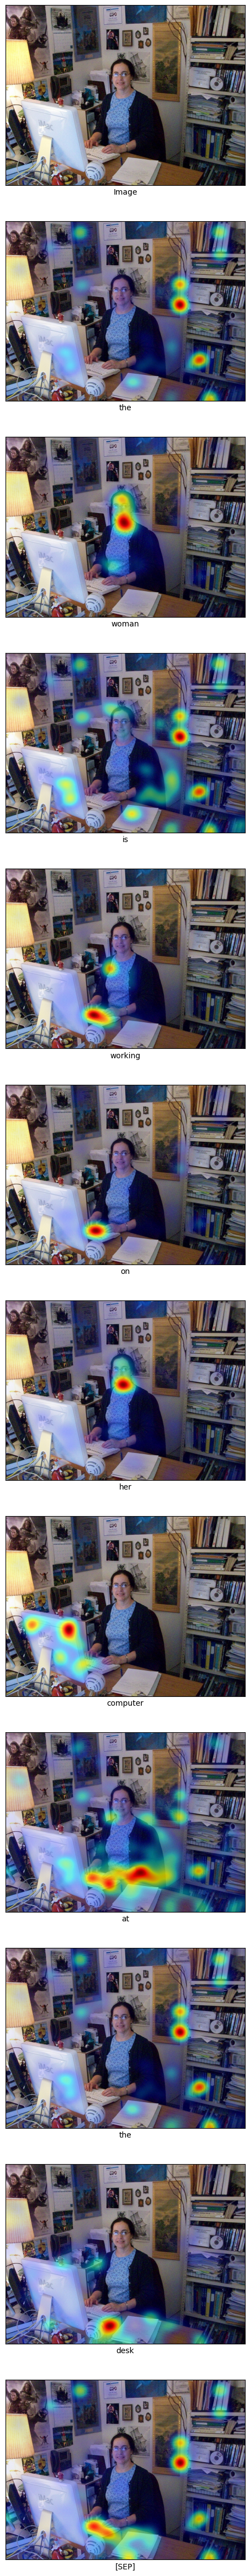

In [ ]:
num_image = len(text_input.input_ids[0])
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")

for i,token_id in enumerate(text_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)